In [ ]:
from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# Download necessary NLTK resources
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd

# Load the dataset
file_path = 'Reviews.csv'
df = pd.read_csv(file_path)
# df.head()

In [ ]:
df.shape

(568454, 10)

In [ ]:
df.drop_duplicates(subset=['Text'], inplace=True)
df.shape

(393579, 10)

In [ ]:
# Give reviews with Score>3 a positive rating "1", and reviews with score<3 a negative rating "0"
def partition(x):
    if x <= 3:
        return 0
    return 1

Score = df['Score']
positiveNegative = Score.map(partition)
df['Score'] = positiveNegative
# df.head()

## Exploratory Data Analysis

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Score'>

Text(0.5, 1.0, 'Value Counts of Score Column')

Text(0.5, 0, 'Score')

Text(0, 0.5, 'Count')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

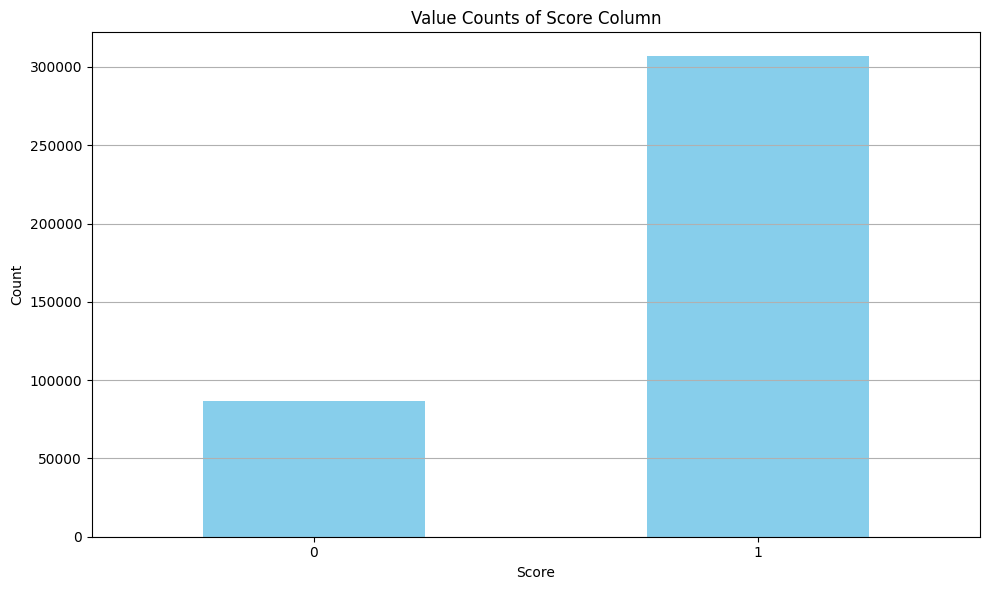

In [ ]:
import matplotlib.pyplot as plt

# Get value counts of "Score" column
score_counts = df["Score"].value_counts()

# Sort the value counts by index
score_counts = score_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
score_counts.plot(kind='bar', color='skyblue')

plt.title('Value Counts of Score Column')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

EDA Findings

*   Target variable "Score" is extremely biased towards the positve sentiment. Data must be undersampled from the majority class to overcome this issue.


In [ ]:
# Preview biased column
df["Score"].value_counts()

Score
1    306758
0     86821
Name: count, dtype: int64

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Undersampling majority class
df_majority = df[df['Score'] == 1]
df_minority = df[df['Score'] == 0]

# Downsample the majority class to 50,000 rows
df_majority_downsampled = resample(df_majority, replace=False, n_samples=50000, random_state=42)

# Downsample the minority class to 50,000 rows
df_minority_downsampled = resample(df_minority, replace=False, n_samples=50000, random_state=42)

# Combine the downsampled majority and minority classes
df_balanced = pd.concat([df_majority_downsampled, df_minority_downsampled])

# Verify the class balance
print(df_balanced['Score'].value_counts())

Score
1    50000
0    50000
Name: count, dtype: int64


In [ ]:
df_balanced.shape

(100000, 10)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Score'>

Text(0.5, 1.0, 'Value Counts of Score Column')

Text(0.5, 0, 'Score')

Text(0, 0.5, 'Count')

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

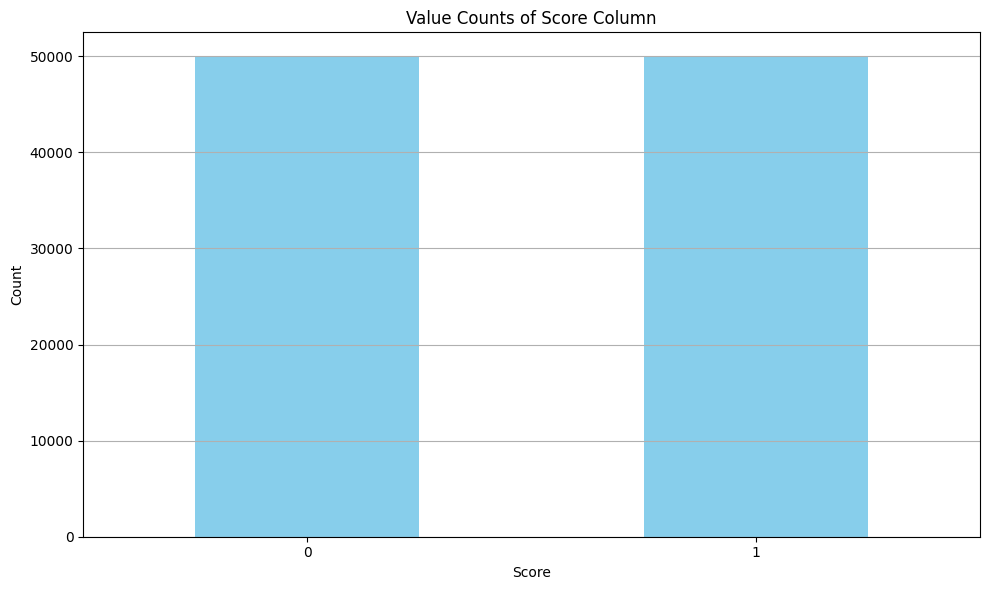

In [ ]:
import matplotlib.pyplot as plt

# Get value counts of "Score" column
score_counts = df_balanced["Score"].value_counts()

# Sort the value counts by index
score_counts = score_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
score_counts.plot(kind='bar', color='skyblue')

plt.title('Value Counts of Score Column')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

The target variable is no longer biased towards the majority class.

# Preprocessing

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

texts = df_balanced['Text'].astype(str)


def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize the text data
    text = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    # Join the cleaned tokens back into a string
    text = ' '.join(text)
    return text


# Apply preprocessing to each review
cleaned_texts = texts.apply(clean_text)
cleaned_texts[:5]

515173    dr mcdougalls organic maple brown sugar light ...
427248    started new keurig brewer tried 40 different c...
564976    first took 2 day get place 3 container inside ...
40391     cereal healthy source fiber breakfast day use ...
335745    normally despise gatorade product make stomach...
Name: Text, dtype: object

In [ ]:
len(cleaned_texts)

100000

# Bert

In [ ]:
#pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained Albert model
model = SentenceTransformer('albert-base-v2')

review_embeddings = model.encode(list(cleaned_texts))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
import numpy as np

# Mount your Google Drive
drive.mount('/content/drive')

# Save the embeddings to a file
np.save('/content/drive/MyDrive/100000_albert_embeddings.npy', review_embeddings)

Mounted at /content/drive


In [ ]:
from google.colab import drive
import numpy as np

# Mount your Google Drive
drive.mount('/content/drive')

review_embeddings = np.load('/content/drive/MyDrive/100000_albert_embeddings.npy')

Mounted at /content/drive


# Split

In [ ]:
# Assume 'labels' is already defined
labels = df_balanced['Score']

# Convert 'review_embeddings' to a numpy array
review_embeddings = np.array(review_embeddings)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(review_embeddings, labels, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (80000, 768)
Shape of y_train: (80000,)
Shape of X_test: (20000, 768)
Shape of y_test: (20000,)


### Neural Network

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Define the neural network model
nn_model = Sequential([
    Dense(256, activation='relu', input_dim=review_embeddings.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
nn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
2500/2500 [==============================] - 14s 4ms/step - loss: 0.4911 - accuracy: 0.7634 - val_loss: 0.4531 - val_accuracy: 0.7887
Epoch 2/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4556 - accuracy: 0.7876 - val_loss: 0.4407 - val_accuracy: 0.7931
Epoch 3/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4458 - accuracy: 0.7932 - val_loss: 0.4381 - val_accuracy: 0.7972
Epoch 4/20
2500/2500 [==============================] - 9s 3ms/step - loss: 0.4402 - accuracy: 0.7953 - val_loss: 0.4290 - val_accuracy: 0.8009
Epoch 5/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4352 - accuracy: 0.8000 - val_loss: 0.4275 - val_accuracy: 0.8004
Epoch 6/20
2500/2500 [==============================] - 10s 4ms/step - loss: 0.4303 - accuracy: 0.8011 - val_loss: 0.4241 - val_accuracy: 0.8041
Epoch 7/20
2500/2500 [==============================] - 9s 4ms/step - loss: 0.4259 - accuracy: 0.8045 - val_loss: 0.4270 - val_accur

### Evaluation of the model

In [ ]:
from sklearn.metrics import classification_report

# Predict on test data
y_pred = nn_model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Convert y_test to binary (0 or 1)
y_test_binary = (y_test >= 0.5).astype(int)

# Generate classification report
print(classification_report(y_test_binary, y_pred))

625/625 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      9965
           1       0.81      0.82      0.81     10035

    accuracy                           0.81     20000
   macro avg       0.81      0.81      0.81     20000
weighted avg       0.81      0.81      0.81     20000



<Figure size 800x600 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 36.72222222222221, 'Predicted Labels')

Text(70.72222222222221, 0.5, 'True Labels')

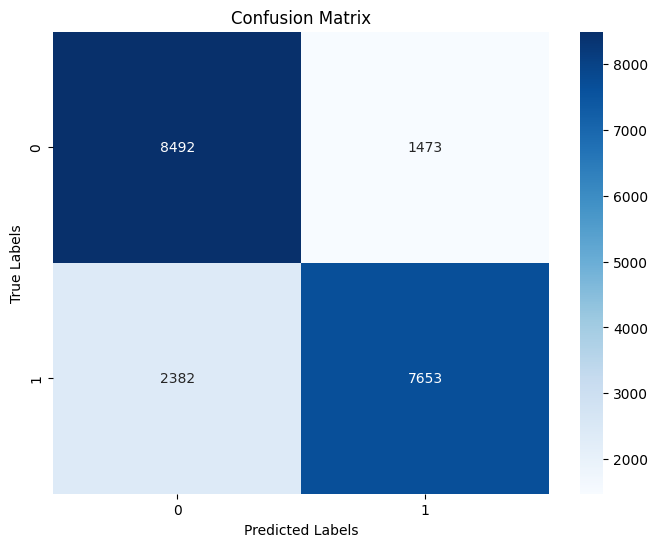

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# HyperParameter Tuning

In [ ]:
import kerastuner as kt
import tensorflow as tf

def build_model(hp):
    # Define the hyperparameters to tune
    units_1 = hp.Int('units_1', min_value=128, max_value=512, step=32)
    dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    units_2 = hp.Int('units_2', min_value=64, max_value=256, step=32)
    dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Define the model architecture
    model = Sequential([
        Dense(units=units_1, activation='relu', input_dim=review_embeddings.shape[1]),
        BatchNormalization(),
        Dropout(rate=dropout_1),
        Dense(units=units_2, activation='relu'),
        BatchNormalization(),
        Dropout(rate=dropout_2),
        Dense(units=1, activation='sigmoid')
    ])

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the tuner
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of trial runs
    seed=42,  # Set a random seed for reproducibility
    directory='tuner_results',
    project_name='text_classification'
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Get the best hyperparameters and the best model
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hyperparameters.values}")

best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
#pip install keras-tuner

### Topic Modelling

In [ ]:
import gensim
from gensim import corpora
import nltk

# Assuming cleaned_texts is a list of strings
cleaned_texts = list(cleaned_texts)

# Tokenize each document
tokenized_texts = [nltk.word_tokenize(text) for text in cleaned_texts]

# Create a dictionary from the tokenized texts
dictionary = corpora.Dictionary(tokenized_texts)

# Create a corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# Build the LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=8)

# Print the topics and their associated words
print(lda_model.print_topics())

# Assign topic labels to each document
doc_lda = lda_model[corpus]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[(0, '0.026*"taste" + 0.024*"like" + 0.013*"flavor" + 0.012*"one" + 0.010*"tasted" + 0.010*"tried" + 0.008*"dont" + 0.008*"ever" + 0.007*"even" + 0.007*"ive"'), (1, '0.020*"box" + 0.016*"bag" + 0.015*"product" + 0.011*"like" + 0.011*"would" + 0.010*"one" + 0.010*"good" + 0.010*"bar" + 0.008*"candy" + 0.008*"package"'), (2, '0.037*"coffee" + 0.029*"tea" + 0.024*"taste" + 0.020*"like" + 0.018*"flavor" + 0.013*"drink" + 0.012*"cup" + 0.010*"good" + 0.009*"water" + 0.008*"one"'), (3, '0.025*"juice" + 0.016*"sugar" + 0.015*"bottle" + 0.014*"vitamin" + 0.014*"price" + 0.013*"syrup" + 0.012*"per" + 0.011*"soda" + 0.010*"ounce" + 0.009*"fruit"'), (4, '0.018*"oil" + 0.016*"use" + 0.014*"water" + 0.011*"hair" + 0.010*"noodle" + 0.009*"coconut" + 0.008*"make" + 0.008*"soup" + 0.007*"pasta" + 0.007*"used"'), (5, '0.024*"taste" + 0.022*"like" + 0.017*"chocolate" + 0.014*"flavor" + 0.012*"good" + 0.009*"would" + 0.007*"sugar" + 0.007*"really" + 0.007*"one" + 0.007*"sweet"'), (6, '0.020*"food" + 0.01

In [ ]:
pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.9 MB/s eta 0:00:00


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.051434  0.029316       1        1  20.556626
5     -0.026674 -0.062876       2        1  19.612523
2     -0.021742 -0.057697       3        1  17.361530
7     -0.042817  0.160603       4        1  14.211101
1     -0.057402  0.084594       5        1  10.247104
4     -0.025538 -0.191056       6        1   7.739583
0     -0.056775  0.014894       7        1   6.616872
3      0.282382  0.022222       8        1   3.654661, topic_info=           Term          Freq         Total Category  logprob  loglift
57       coffee  26994.000000  26994.000000  Default  30.0000  30.0000
860         tea  21288.000000  21288.000000  Default  29.0000  29.0000
337       taste  50380.000000  50380.000000  Default  28.0000  28.0000
711   chocolate  14102.000000  14102.000000  Default  27.0000  27.0000
347         dog  13276.000000  13276.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
397         buy    780.737694  15942.808545   Topic8  -5.2764   0.2926
562        much    749.274425  18572.645728   Topic8  -5.3175   0.0988
99          get    733.960978  21366.574340   Topic8  -5.3381  -0.0620
408      flavor    732.525741  32891.343463   Topic8  -5.3401  -0.4953
330  ingredient    693.970362  10621.828059   Topic8  -5.3942   0.5809

[711 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
940       1  0.113188    100
940       2  0.169532    100
940       3  0.133133    100
940       4  0.043380    100
940       5  0.100722    100
...     ...       ...    ...
626       2  0.199090   yuck
626       3  0.146427   yuck
626       7  0.602408   yuck
6007      3  0.018167  zevia
6007      8  0.974975  zevia

[2321 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 3, 8, 2, 5, 1, 4])

The topic modeling revealed distinct product categories, including coffee, pet food, snacks, and tea, helping businesses identify popular product areas. For each category, key attributes such as taste and flavor for coffee, ingredients for pet food, and sweetness for snacks were highlighted, offering valuable insights to guide marketing and product development strategies.